# i1_graph 
File that contain all analysis done on Graph constructed with interactions

In [1]:
import networkx as nx
import import_ipynb
import h2_ENb_gen as h2
import h1_ENB_occ as h1
import g1_generate_dictionary as g1
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import pandas as pd
import pycountry
import numpy as np
import random 
import networkx.algorithms.community
import community
from community import community_louvain
import matplotlib.patches as mpatches

importing Jupyter notebook from h2_ENb_gen.ipynb
importing Jupyter notebook from c1_extract_paragraphe_issue.ipynb
importing Jupyter notebook from c2_extract_sentence_issue.ipynb
importing Jupyter notebook from g1_generate_dictionary.ipynb
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
importing Jupyter notebook from h1_ENB_occ.ipynb


In [2]:
# Dictionary for each COP (key) with the issues related to it (values)
dict_cop = {1: np.arange(12,22),
            2: np.arange(29,38),
            3: np.arange(68,76),
             4: np.arange(88,97),
             5 : np.arange(113,123),
             6: np.arange(153,163),
             7: np.arange(179,189),
             8: np.arange(200,209),
             9: np.arange(222,230),
             10: np.arange(250,260),
             11: np.arange(281,291),
             12: np.arange(308,318),
             13: np.arange(344,354),
             14: np.arange(386,395),
             15: np.arange(449,459),
             16: np.arange(488,497),
             17: np.arange(524,534),
             18: np.arange(557,567),
             19: np.arange(584,593),
             20 : np.arange(609,619),
             21: np.arange(653,663),
             22: np.arange(679,689),
             23: np.arange(704,714),
             24: np.arange(736,747),
             25: np.arange(765,774)}

In [3]:
def create_dict():
    """Create dictionary that can map entities with an id but also map entities from the original to the generated dataset. """
    DICTIONARY = g1.compute_dictionary()
    n = 0
    DICTIONARY_NUM = dict()
    for k in DICTIONARY:

        DICTIONARY_NUM[n] = k
        n +=1
    NAMES = []
    for x in DICTIONARY.values():
        if(len(x) == 1):
            NAMES.append(x[0])

        else:
            NAMES += [k for k in x]
    return DICTIONARY, DICTIONARY_NUM, NAMES

In [4]:
DICTIONARY, DICTIONARY_NUM, NAMES = create_dict()

In [5]:
def  extract_df_cop1(cooperation,issue_cop):
    """Create the dataframe with all the interactiom ,if the cooperation = True, return all the cooperation otherwise all the oppositions. """
    frames = []
    for i in issue_cop:
        df = h1.extract_relationships_count(i)[0]
        frames.append(df)
    df_combine = pd.concat(frames)
    df_combine['Country A'] = df_combine['Country A'].apply(lambda x: x.upper())
    df_combine['Country B'] = df_combine['Country B'].apply(lambda x: x.upper())
    df_combine= df_combine.drop(['type','issue','behalf','support','agreement','opposition','criticism','sentences'],axis = 1)
    if(cooperation):
        df_combine = df_combine.loc[df_combine['cooperation'] == 1]
    else : 
        df_combine = df_combine.loc[df_combine['cooperation'] == 0]

    grouped = df_combine.groupby(['id_ca','id_cb','Country A','Country B'],as_index=False).count()

    
    return grouped

In [6]:
def extract_df_cop(issue_cop, cooperation):
    """Create the dataframe with all the interactiom ,if the cooperation = True, return all the cooperation otherwise all the oppositions. """
    frames = []
    for i in issue_cop:
        df = h2.interactions(i)[0]
        frames.append(df)
    df_combine = pd.concat(frames)
    df_combine['Country A'] = df_combine['Country A'].apply(lambda x: x.upper())
    df_combine['Country B'] = df_combine['Country B'].apply(lambda x: x.upper())
    df_combine= df_combine.drop(['type','issue'],axis = 1)
    df_support = df_combine.loc[df_combine['agreement'] == 1].drop_duplicates(keep = False)
    num_support = len(df_support.to_numpy())
    print(len(df_combine['Country A'].to_numpy()))
    df_combine= df_combine.drop(['behalf','support','agreement','opposition','criticism','sentences'],axis = 1)
    if(cooperation):
        df_combine = df_combine.loc[df_combine['cooperation'] == 1]
    else : 
        df_combine = df_combine.loc[df_combine['cooperation'] == 0]

    grouped = df_combine.groupby(['id_ca','id_cb','Country A','Country B'],as_index=False).count()

    
    return grouped

In [7]:
def graph_cop(df_cop, direct):
    """Create the directed weighted graph from the dataframe. """
    if(direct):
        G=nx.DiGraph()
        print('bof')
    else :
        G = nx.Graph()
    #Creates nodes
    nodes =  list(set(list(df_cop['id_ca'].to_numpy()) + list(df_cop['id_cb'].to_numpy())))
    G.add_nodes_from(nodes)
    # Create edges
    edges = list(zip(df_cop['id_ca'], df_cop['id_cb']))
    G.add_edges_from(edges)
     # Create weights of the edges
    df_edges = df_cop.drop(['Country A','Country B'], axis = 1)
    list_weigths = list(df_edges.to_records(index = False))
    G.add_weighted_edges_from(list_weigths)
    
    return G, list_weigths

In [8]:
def plot_graph(G, issue_cop):
    """Plot the directed weighted graph from the dataframe. """
    pos = nx.spring_layout(G, k=2.5)
    figsize = (30,15)
    fig, axe = plt.subplots(1, 1, figsize=figsize)
    s = ""
    plt.title(s, fontsize=18)
    names = dict([(n,DICTIONARY_NUM[n]) for n in G.nodes])
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    labels=nx.draw_networkx_labels(G,pos=pos, labels= names,font_size = 20 ,font_color = 'k',font_weight='bold')
    nx.draw_networkx(G, pos = pos, edges=edges, edge_color='grey', node_size=10, node_color ='k',width = weights, arrows = True, with_labels=False)

In [9]:
def centrality(dict_cent, x):
    """Find of the node if it is present during negotiation of a specific COP. """
    if(x in dict_cent):
        return dict_cent[x]
    else :
        return 0

In [10]:
def keek_c():
    df_ch = pd.DataFrame()
    df_us = pd.DataFrame()
    df_swiss = pd.DataFrame()
    df_tu = pd.DataFrame()
    df_eu = pd.DataFrame()
    for i in range(1,26):
        frames_ch = []
        frames_us = []
        frames_croatia = []
        frames_tuv = []
        frames_eu = []
        for j in dict_cop[i]:
            df = h2.interactions(j)[0]
            df['cop'] = i
            df_ch = pd.concat([df_ch,df.loc[(df['id_ca'] == 44) | (df['id_cb'] == 44)]])
            df_us = pd.concat([df_us,df.loc[(df['id_ca'] == 114) | (df['id_cb'] == 114)]])
            df_swiss = pd.concat([df_swiss,df.loc[(df['id_ca'] == 129) | (df['id_cb'] == 129)]])
            df_tu = pd.concat([df_tu,df.loc[(df['id_ca'] == 138) | (df['id_cb'] == 138)]])
            df_eu = pd.concat([df_eu,df.loc[(df['id_ca'] == 139) | (df['id_cb'] == 139)]])

    
    return  df_ch, df_us, df_swiss, df_tu, df_eu

In [11]:
def pageRank_COP(cop_number) :
    """Find the PageRank score of each node present in the Graph of a specific COP. """
    issues_cop = dict_cop[cop_number]
    df_cop = extract_df_cop(issues_cop, True)
    G_cop, list_weights = graph_cop(df_cop, True)
    pr = nx.pagerank(G_cop)
    return pr

In [16]:
num = []
for i in range(1,26):
    issue_cop = dict_cop[i]
    df_cop =extract_df_cop(issue_cop, cooperation = True)
    g_cop = graph_cop(df_cop, direct= True)
    num.append(g_cop[0].number_of_nodes())
    print(g_cop[0].number_of_nodes())
    



Issue  12
Supported by UNEP and WMO, the mandate of the INC/FCCC was to prepare an effective framework convention on climate change. 12
Issue  13
Issue  14
Issue  15
Issue  16
Issue  17
Issue  18
Issue  19
Issue  20
Issue  21
Supported by Indonesia, he stressed the need for a protocol that imposes commitments only on Annex I Parties. 21
Supported by UNEP and WMO, the mandate of the INC/FCCC was to prepare an effective framework convention on climate change. 21
1350
bof
96
Issue  29
Issue  30
Issue  31
Issue  32
Issue  33
Supported by MALAYSIA, he stated that Annex I data was not comparable to Annex II data. 33
Issue  34
Issue  35
Issue  36
Issue  37
954
bof
71
Issue  68
Issue  69
Issue  70
Issue  71
Issue  72
Supported by HUNGARY, the US, CANADA, the EU, POLAND, SLOVENIA, AUSTRALIA, SWITZERLAND, and JAPAN, he introduced a draft text that, inter alia: notes Annex I Party commitments through 2014; considers that future Annex I commitments beyond that date should comprise the widest possi

In [20]:
print(np.std(num))

20.158412635919525


In [31]:
china = np.zeros(25)
us = np.zeros(25)
swiss = np.zeros(25)
tuvalu = np.zeros(25)
eu = np.zeros(25)
for i in range(1,26):

    china[i-1] = page_score[i-1][44]
    us[i-1] = page_score[i-1][114]
    if(129 in page_score[i-1]):
        swiss[i-1] = page_score[i-1][129]
    if(138 in page_score[i-1]):
        tuvalu[i-1] = page_score[i-1][138]
    if(139 in page_score[i-1]):
        eu[i-1] = page_score[i-1][139]

In [8]:
def compute_centrality_COP(cop_number,top_n, print_top):
    """Find the centrality of each node present in the Graph of a specific COP. """
    
    #Create dataframe with nodes and centrality for first COP 
    df_nodes = pd.DataFrame()
    df_nodes['id_c'] = list(DICTIONARY_NUM.keys())
    df_nodes['Country'] = df_nodes['id_c'].apply(lambda x : DICTIONARY_NUM[x])
    issues_cop = dict_cop[cop_number]
    df_cop = extract_df_cop(issues_cop, True)
    G_cop, list_weights = graph_cop(df_cop, False)
    cent_deg_dict = nx.degree_centrality(G_cop)
    cent_s = 'centrality COP'+str(cop_number)
    df_nodes[cent_s] = df_nodes['id_c'].apply(lambda x : centrality(cent_deg_dict, x))
    df_nodes = df_nodes.drop(['Country'],axis = 1)
    list_tuples = [tuple(x) for x in df_nodes.to_numpy()]
    idc = [int(x[0]) for x in list_tuples]
    val = [x[1] for x in list_tuples]
    return dict(list(zip(idc,val)))

In [32]:
def plot_interactions_rank_COP(china, us, croatia, tuvalu, eu):
    """Plot for Switzerland, US, China, Saudi Arabia and Tuvalu their score (PageRak or Centrality) for all COPs. """
    
    #Plot the interventions
    index = np.arange(1,26)
    figsize = (24,9)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    csfont = {'fontname':'Helvetica','fontsize':'18' }
    hfont = {'fontname':'Helvetica','fontsize':'16'}

    #plt.title('PageRank Score for five entities',**csfont)
    plt.xlabel("COPs in chronological order", **hfont)
    plt.ylabel("PageRank Score", **hfont)

    x = index
    red_patch = mpatches.Patch(color='limegreen', label='United States')
    c_patch = mpatches.Patch(color='red', label='China')
    b_patch = mpatches.Patch(color='dodgerblue', label='Switzerland')
    a_patch = mpatches.Patch(color='darkorange', label='EU')
    t_patch = mpatches.Patch(color='purple', label='Tuvalu')
    plt.legend(handles=[b_patch,c_patch,red_patch, a_patch, t_patch])
    plt.plot(x, swiss, color='dodgerblue', marker='o', linestyle='dashed',linewidth=2, markersize=12)
    plt.plot(x, china, color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)
    plt.plot(x, us, color='limegreen', marker='o', linestyle='dashed',linewidth=2, markersize=12)
    plt.plot(x, eu, color='darkorange', marker='o', linestyle='dashed',linewidth=2, markersize=12)
    plt.plot(x, tuvalu, color='purple', marker='o', linestyle='dashed',linewidth=2, markersize=12)
    
    """ax.bar(x-0.3, swiss, width=0.15, color='dodgerblue', align='center')
    ax.bar(x-0.15, china, width=0.15, color='red', align='center')
    ax.bar(x+0.0, us, width=0.15, color='limegreen', align='center')
    ax.bar(x+0.15, g77, width=0.15, color='darkorange', align='center')
    ax.bar(x+0.3, brazil,  width=0.15, color='yellow', align='center') """
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))

    plt.show()

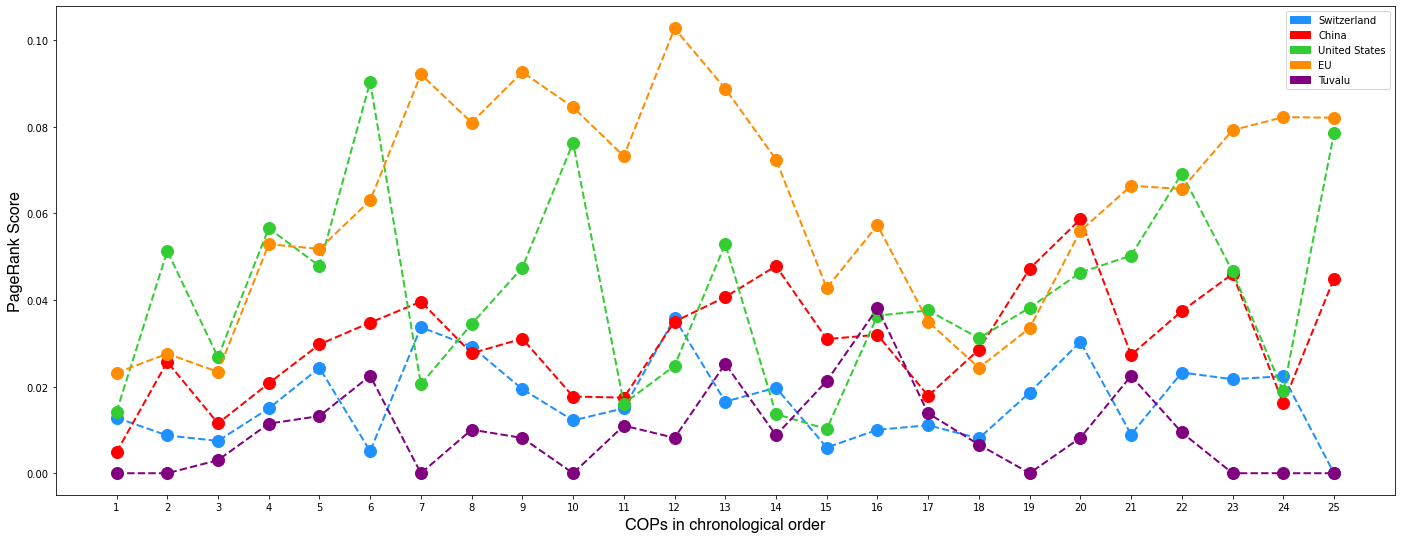

In [33]:
plot_interactions_rank_COP(china, us, swiss, tuvalu, eu)

In [31]:
def ego_graph(entity, df_cop):
    """Return the Ego graph during a specific COP of one entity. """
    df_ego = df_cop.loc[df_cop['Country A'].isin([entity])]
    #out = df_cop.loc[df_cop['Country A'].isin(['CROATIA']) & df_cop['Country B'].isin(['EU'])]
    #in_ = df_cop.loc[df_cop['Country B'].isin(['CROATIA']) & df_cop['Country A'].isin(['EU'])]

    G_cop,l = graph_cop(df_ego, direct = False)
    return G_cop

In [40]:
issues_cop = dict_cop[12]
df_cop = extract_df_cop(issues_cop, True)
g = ego_graph('SWITZERLAND', df_cop)


Issue  308
Issue  309
Issue  310
Issue  311
Issue  312
Issue  313
Issue  314
Issue  315
Issue  316
Issue  317
342


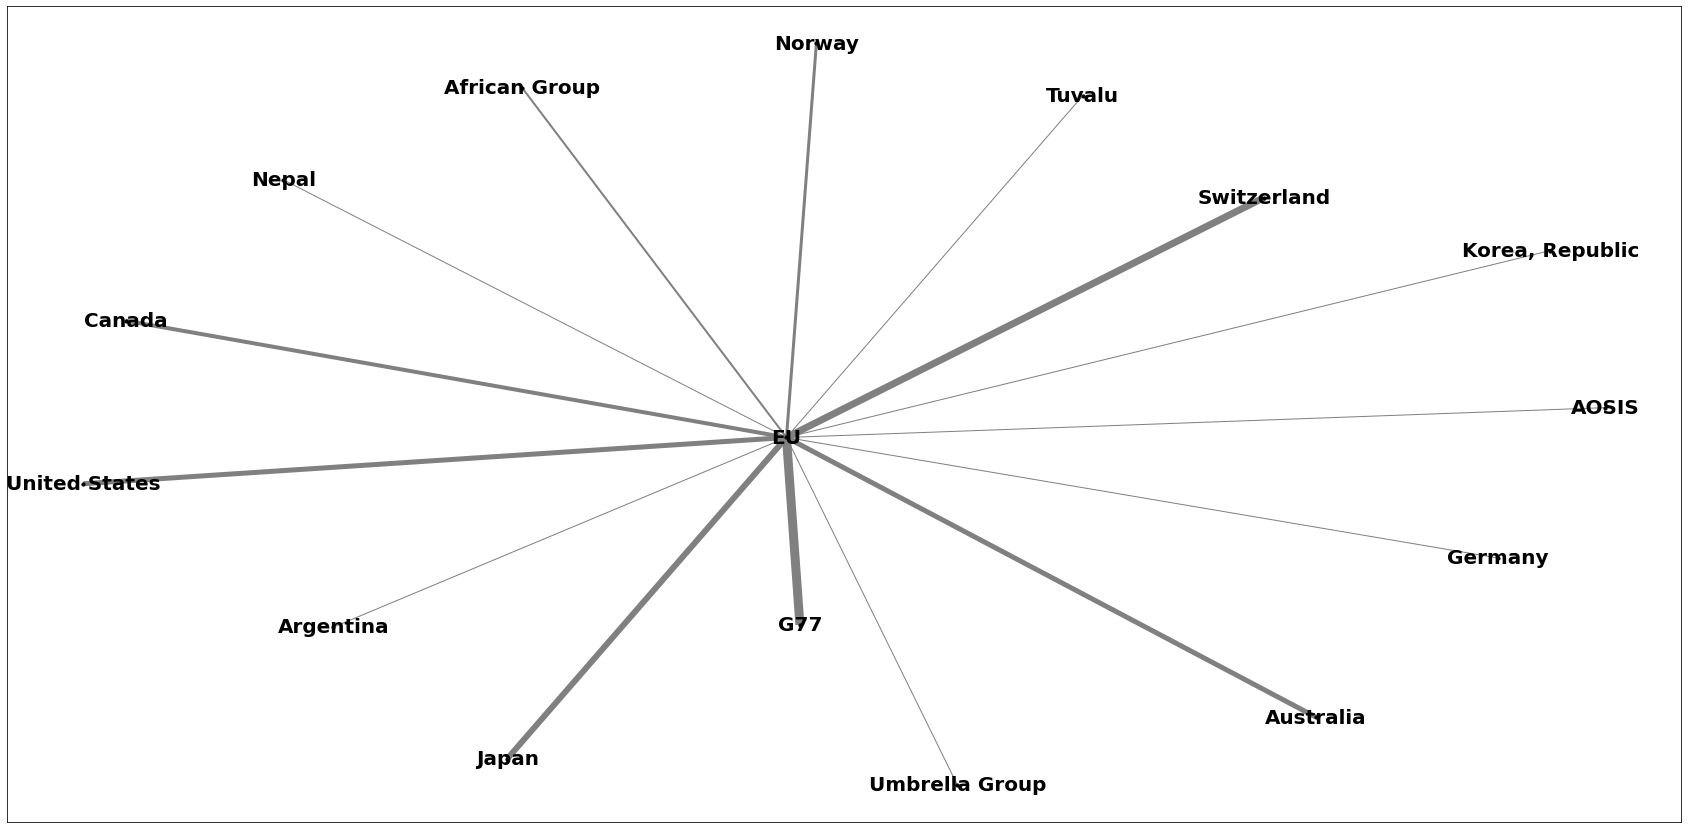

In [41]:
plot_graph(g, 14)

In [37]:
list(g.nodes(weights))

NameError: name 'weights' is not defined

In [35]:
DICTIONARY_NUM

{0: 'Liechtenstein',
 1: 'Cambodia',
 2: 'Portugal',
 3: 'Nicaragua',
 4: 'Jamaica',
 5: 'Russian Federation',
 6: 'Venezuela',
 7: 'Southern Africa Development Community',
 8: 'Guyana',
 9: 'Haiti',
 10: 'Lithuania',
 11: 'St. Vincent and the Grenadines',
 12: 'Uzbekistan',
 13: 'Group of 9',
 14: 'South Africa',
 15: 'Brunei',
 16: 'Ethiopia',
 17: 'Japan',
 18: 'Sri Lanka',
 19: 'Equatorial Guinea',
 20: 'France',
 21: 'Bolivia',
 22: 'Afghanistan',
 23: 'Kazakhstan',
 24: 'Kyrgyz Republic',
 25: 'Eritrea',
 26: 'Lao PDR',
 27: 'Mauritius',
 28: 'Togo',
 29: 'AILAC',
 30: 'African Group',
 31: 'Brazil',
 32: 'Cameroon',
 33: 'Peru',
 34: 'Australia',
 35: 'ALBA',
 36: 'Cuba',
 37: 'Lesotho',
 38: 'Slovenia',
 39: 'Philippines',
 40: 'Yemen',
 41: 'Cape Verde',
 42: 'Italy',
 43: 'Austria',
 44: 'Bulgaria',
 45: 'Papua New Guinea',
 46: 'New Zealand',
 47: 'El Salvador',
 48: 'Barbados',
 49: 'Hungary',
 50: 'Namibia',
 51: 'Netherlands',
 52: 'Iran',
 53: 'Paraguay',
 54: 'Tuvalu',
